<a href="https://colab.research.google.com/github/kishanAk21/Restricted_Boltzmann_Machine_for_Reco_Sys/blob/main/main_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement¶
Aim of this exercise is to get initial insights of the online purchase dataset and recommend related products to user based on similar other users. 

We would be using Restricted Boltzmann Machines (RBMs) algorithm for developing recommender system model. The process for developing recommender system using RBMs is highlighed here.

- Data Cleaning and Pre-processing: Initially we would clean and pre-process the dataset to make it ready for model training purpose.
- Model Functions: We would develop a few functions that would be useful in model training.
- Model Training: This step includes training the model with batches. It includes updating weights, hidden bias and visible bias parameters.
- Model testing: We would select one test case to illustrate model's performance on it. 


You can learn the basic theory behind RBMs here. https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine

You can check out this practical guide on training RBMs here. https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf


In [136]:
# Dependencies

import tensorflow as tf

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [137]:
# Mouting Gdrive for data

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [138]:
# Reading Dataset from Gdrive

data = pd.read_csv('/content/drive/MyDrive/sample30.csv')
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


Here we only need columns 'name' --> Product Name, 'reviews_username' --> User Name, and 'reviews_rating' --> Rating. We would drop other columns as they would not add any value to our model.

In [139]:
# Redefining ratings data
ratings = data[['name', 'reviews_username', 'reviews_rating']]

# dropping rows with null entires in 'reviews_username' column
ratings = ratings.dropna(axis=0,
                        subset = ['reviews_username'])

ratings.head()

,name,reviews_username,reviews_rating
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,K-Y Love Sensuality Pleasure Gel,walker557,1


There might be some duplucate data entry as well. We would make sure to avoid them as they can create data duplication and overfitting problems.

In [140]:
# dropping duplicate rows (except first entry)

ratings.drop_duplicates(inplace=True)
ratings.shape

(27739, 3)

In [141]:
# Keep last in case of multiple ratings by a user for the same product

ratings.drop_duplicates(subset = ['name', 'reviews_username'], keep='last', inplace=True)
ratings.head()

,name,reviews_username,reviews_rating
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,K-Y Love Sensuality Pleasure Gel,walker557,1
5,K-Y Love Sensuality Pleasure Gel,samantha,1


In [142]:
ratings.shape

(27588, 3)

Label encoding helps converting string based data into numeric entries.

In [143]:
# label_encoder1
label_encoder1 = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
ratings['reviews_username'] = label_encoder1.fit_transform(ratings['reviews_username'])


# label_encoder2
label_encoder2 = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
ratings['name'] = label_encoder2.fit_transform(ratings['name'])


ratings.head()

,name,reviews_username,reviews_rating
0,182,11440,5
1,140,6974,5
3,120,19327,1
4,120,24205,1
5,120,20202,1


In [144]:
# Defining User-Product dataframe

user_rating_df = ratings.pivot(index='reviews_username', columns='name', values='reviews_rating')
user_rating_df.head()

name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here, we want to convert the explicit ratings into implicit for better learning by RBM algorithm. We woud map null, 1s and 2s to 0 and 3s, 4s, and 5s to 1. This basicaly means a product is liked by a user only if rating provided is 3 or above.

In [145]:
# Normalizing dataframe
user_rating_df = user_rating_df/user_rating_df.max().max() # rating pre-processing method-1
norm_user_rating_df = user_rating_df.fillna(0)
# norm_user_rating_df = norm_user_rating_df.replace({1:0, 2:0, 3:1, 4:1, 5:1}) # rating pre-processing method-2

trainingset, testset = train_test_split(norm_user_rating_df, train_size=0.75, random_state=2021)
print(len(trainingset), len(testset))


trX = trainingset.values
trX[0:5]


trX_test = testset.values
trX_test[0:5]

18685 6229


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [146]:
# Defining hidden layer bias, visible layer bias and weights

hiddenUnits = 64
visibleUnits =  len(user_rating_df.columns)

vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32) # visible layer bias
hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32) # hidden layer bias

weight_initer = tf.initializers.RandomNormal(stddev=0.01)
W = tf.Variable(weight_initer(shape=(visibleUnits, hiddenUnits)))

In [147]:
# Printing W (weight array)

W

<tf.Variable 'Variable:0' shape=(271, 64) dtype=float32, numpy=
array([[-0.00279447,  0.00327322,  0.00430343, ...,  0.00850983,
        -0.00712614,  0.00084208],
       [ 0.02913277,  0.01479654, -0.00257468, ...,  0.02176995,
        -0.00124882, -0.00646622],
       [-0.0075614 ,  0.0251128 , -0.0009249 , ..., -0.01546983,
         0.00998022,  0.00496836],
       ...,
       [-0.00075755,  0.00228818, -0.0099827 , ..., -0.00201561,
         0.0022951 ,  0.0256034 ],
       [-0.00908364,  0.00552514,  0.00759977, ..., -0.00810154,
        -0.01161619,  0.00142014],
       [-0.0042706 ,  0.00320015,  0.00583229, ..., -0.00387945,
         0.00788819, -0.00263828]], dtype=float32)>

Let's define functions to be used while model training process. 

In [148]:
# defining a function to return generated hidden states 
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.reshape(tf.nn.sigmoid(tf.matmul(v0_state, W) + hb), [-1,hiddenUnits]) 
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) 
    return h0_prob, h0_state

# Defining function to return recalculated visible states 
def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) 
    return v1_prob, v1_state

# Defining function for RMSE
def error(v0_state, v1_state):
    return tf.math.reduce_mean(tf.math.sqrt(tf.reduce_mean(tf.square(v0_state - v1_state))))

epoch: 1 Train reconstruction error: 0.116728 validation reconstruction error: 0.11656772
epoch: 2 Train reconstruction error: 0.0933599 validation reconstruction error: 0.09656374
epoch: 3 Train reconstruction error: 0.090697356 validation reconstruction error: 0.09020028
epoch: 4 Train reconstruction error: 0.09164124 validation reconstruction error: 0.08776161
epoch: 5 Train reconstruction error: 0.08841736 validation reconstruction error: 0.08623016
epoch: 6 Train reconstruction error: 0.08727172 validation reconstruction error: 0.08464792
epoch: 7 Train reconstruction error: 0.081820376 validation reconstruction error: 0.08484225
epoch: 8 Train reconstruction error: 0.081373505 validation reconstruction error: 0.08457301
epoch: 9 Train reconstruction error: 0.08412315 validation reconstruction error: 0.08337232
epoch: 10 Train reconstruction error: 0.08374084 validation reconstruction error: 0.08212233
epoch: 11 Train reconstruction error: 0.080508575 validation reconstruction err

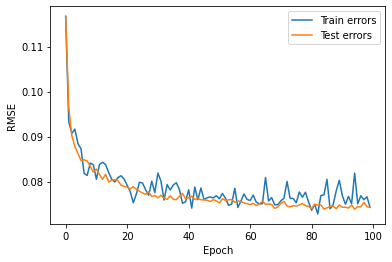

In [149]:
# Training hyper-parameters
epochs = 100
batchsize = 256
errors = []
errors_test = []
weights = []
alpha = 0.001
cd_loops = 1

# creating datasets
train_ds = tf.data.Dataset.from_tensor_slices((np.float32(trX))).batch(batchsize)

# Model Training
for epoch in range(epochs):
    for batch_x in train_ds:
        v0_state = batch_x
        v1_state = batch_x
        _, v0_prob= hidden_layer(v0_state, W, hb)

        for i in range(cd_loops):
          _, h1_state = hidden_layer(v1_state, W, hb)
          _, v1_state = reconstructed_output(h1_state, W, vb)

          

        v1_prob, _ = hidden_layer(v1_state, W, hb)

        delta_W = tf.matmul(tf.transpose(v0_state), v0_prob) - tf.matmul(tf.transpose(v1_state), v1_prob)
        W = W + alpha * delta_W

        vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
        hb = hb + alpha * tf.reduce_mean(v0_prob - v1_prob, 0) 


        err_train = error(v0_state, v1_state)

    # Train 
    errors.append(err_train.numpy())
    
    # Validation (testset)
    inputUser = tf.convert_to_tensor(trX_test,"float32")
    inputUser1 = inputUser

    _, h1_state = hidden_layer(inputUser1, W, hb)
    _, inputUser1 = reconstructed_output(h1_state, W, vb)

    err_test = error(inputUser, inputUser1)
    errors_test.append(err_test.numpy())

    print ('epoch:', epoch+1, 'Train reconstruction error:', err_train.numpy(), 'validation reconstruction error:', err_test.numpy())
    

plt.plot(errors)
plt.plot(errors_test)
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(["Train errors", "Test errors"], loc ="upper right")
plt.show()

Now we would check the model performance on one of the test (validation) case.

In [150]:
# Test user case

mock_user_id = 201

In [151]:
# Selecting the input user

inputUser = tf.convert_to_tensor(testset[testset.index == mock_user_id].values,"float32")
v0 = inputUser

In [152]:
# Feeding in the user and reconstructing the input

_, hh0 = hidden_layer(v0, W, hb)
vv1, _ = reconstructed_output(hh0, W, vb)
rec = vv1

In [153]:
scored_movies_df_mock = pd.DataFrame(list(zip(user_rating_df.columns, list(rec[0].numpy()))), columns=['name', 'proba'])
scored_movies_df_mock.sort_values('proba', ascending=False).head(20)

,name,proba
93,93,0.097410
183,183,0.011724
64,64,0.011550
65,65,0.011472
239,239,0.009653
171,171,0.008269
151,151,0.008059
129,129,0.007710
41,41,0.007299
200,200,0.006850


In [154]:
prod_df_mock = ratings[ratings['reviews_username'] == mock_user_id]
prod_df_mock

,name,reviews_username,reviews_rating
87,171,201,3


In [155]:
# Merging prod_df_mock with ratings_df by 'name'

merged_df_mock = scored_movies_df_mock.merge(prod_df_mock, on ='name', how='outer')

In [156]:
merger = data[['brand',	'categories', 'manufacturer', 'name']].drop_duplicates(ignore_index=True)
merger.head()

,brand,categories,manufacturer,name
0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes
2,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel
3,J.R. Watkins,"Personal Care,Skin Care,Hand Cream,Beauty,Body...",J.R. Watkins,"J.R. Watkins Hand Cream, Lemon Cream"
4,AMBI,"Personal Care,Bath, Shower & Soap,Featured Bra...",FLEMING & CO,Ambi Complexion Cleansing Bar


In [157]:
merged_df_mock['product_name'] = label_encoder2.inverse_transform(merged_df_mock['name'])
merged_df_mock.sort_values('proba', ascending=False).merge(merger, right_on='name', left_on='product_name', how='left').head(10)

,name_x,proba,reviews_username,reviews_rating,product_name,brand,categories,manufacturer,name_y
0,93,0.097410,NaN,NaN,Godzilla 3d Includes Digital Copy Ultraviolet ...,Warner Home Video,"Movies, Music & Books,Movies,Action & Adventur...",Test,Godzilla 3d Includes Digital Copy Ultraviolet ...
1,183,0.011724,NaN,NaN,Planes: Fire Rescue (2 Discs) (includes Digita...,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Walt Disney,Planes: Fire Rescue (2 Discs) (includes Digita...
2,64,0.011550,NaN,NaN,Clorox Disinfecting Bathroom Cleaner,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner
3,65,0.011472,NaN,NaN,Clorox Disinfecting Wipes Value Pack Scented 1...,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...
4,239,0.009653,NaN,NaN,The Resident Evil Collection 5 Discs (blu-Ray),Sony Pictures,"Movies, Music & Books,Ways To Shop Entertainme...",SONY CORP,The Resident Evil Collection 5 Discs (blu-Ray)
5,171,0.008269,201.0,3.0,Olay Regenerist Deep Hydration Regenerating Cream,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",P&G,Olay Regenerist Deep Hydration Regenerating Cream
6,151,0.008059,NaN,NaN,Mike Dave Need Wedding Dates (dvd + Digital),FOX,"Movies & TV Shows,Movies,Romance,Romantic Come...",Twentieth Century Fox,Mike Dave Need Wedding Dates (dvd + Digital)
7,129,0.007710,NaN,NaN,L'or233al Paris Elvive Extraordinary Clay Reba...,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...
8,41,0.007299,NaN,NaN,"Burt's Bees Lip Shimmer, Raisin",Burt's Bees,"Personal Care,Makeup,Lipstick, Lip Gloss, & Li...",Burt's Bees,"Burt's Bees Lip Shimmer, Raisin"
9,200,0.006850,NaN,NaN,Red (special Edition) (dvdvideo),Summit Entertainment,"Movies & TV Shows,Instawatch Movies By VUDU,Sh...",Summit Entertainment,Red (special Edition) (dvdvideo)


It can be observed that,
- User '201' has already purchased item '171'. Item '171' is having higher probability value as per our model, which is a good sign.
- Apart from item '171', other items can be recommended to user '201' as per our model.
- Originally bough item belongs to personal skincare category. Some of the recommended items also belong to similar category.

-------------